In [1]:
!pip install strands-agents[mistral] python-dotenv sentence_transformers scikit-learn k-means-constrained

  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 141.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 213.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 51.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 190.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 185.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 102.8 MB/s  0:00:00
Using cached httpx-0.28.1-py3-none-any.whl (73 kB)
Using cached httpcore-1.0.9-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 196.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 137.8 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 20.0 MB/s  0:00:17m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 37

In [3]:
import json
import os
import sys
import dotenv
import numpy as np
import re

import math

import yaml
from pathlib import Path
from tqdm import tqdm

from collections import Counter

from sentence_transformers import SentenceTransformer

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
from sklearn.metrics import silhouette_score

from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer

sys.path.append('..')

from src.utils import (
    save_json,
    read_json,
    load_file_content,
    get_job_paths,
    get_training_paths,
    sanity_check,
	chat_with_persona,
    track_api_call,  # Cost tracking from utils
    print_cost_summary,  # Cost summary from utils
    reset_cost_tracker  # Reset cost tracker from utils
)

from src.my_utils import (
    display_markdown_file,
    call_mistral,
    get_agent,
    batch_extract,
    compute_stat_for_multi_items
)

from src.models.training_info import (
    TrainingInfo
)

# Load API key from .env file
dotenv.load_dotenv("../env")

# Check if we're good to go
if not os.getenv("MISTRAL_API_KEY"):
    print("❌ No MISTRAL_API_KEY found!")
    print("Create an env file with your API key")
else:
    print("✅ API key found, we're ready to roll")

✅ API key found, we're ready to roll


In [4]:
DATA_TRAININGS_DIR = Path('../data_trainings')

In [5]:
with open("../src/config.yaml", "r") as f:
    config = yaml.safe_load(f)

training_data_version = config["training_data_version"]
print(f"training_data_version version: {training_data_version}")

training_data_version version: v7


In [6]:
# Load training data
filename = f"extracted_trainings_{training_data_version}.json"
trainings_save_path = DATA_TRAININGS_DIR / filename
trainings_data = read_json(trainings_save_path)

# Convert to TrainingInfo objects
trainings_info = {
    training_id: TrainingInfo.model_validate_json(data)
    for training_id, data in trainings_data.items()
}

print(f"✅ Loaded {len(trainings_info)} trainings")
print("\n" + "="*50)

✅ Loaded 497 trainings



In [7]:
# Load training descriptions
training_descriptions = {}
training_paths = get_training_paths()
for path in tqdm(training_paths):
    id_ = path.stem
    text = load_file_content(path)
    training_descriptions[id_]=text

# print(training_descriptions)

100%|██████████| 497/497 [00:00<00:00, 1461.86it/s]


# Define functions

In [8]:
def generate_embeddings(training_list):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(training_list, show_progress_bar=True)
    return embeddings

In [9]:
def find_optimal_clusters_random(
    embeddings,
    max_k=15,
    n_init_passes=5,
    algo='KMeans',
    size_max=3
):
    best_silhouette_scores = []
    best_labels_per_k = {}
    best_kmeans_models = {}
    
    min_k = 2
    if algo == 'KMeansConstrained':
        min_k = int(math.ceil(len(embeddings) / size_max))
    
    for k in tqdm(range(min_k, max_k + 1)):
        best_score = -1
        best_labels = None
        best_model = None

        for seed in range(n_init_passes):
            if algo == 'KMeans':
                kmeans = KMeans(n_clusters=k, random_state=seed)
            else:
                kmeans = KMeansConstrained(n_clusters=k, random_state=seed, size_max=size_max)
                
            labels = kmeans.fit_predict(embeddings)
            score = silhouette_score(embeddings, labels)

            if score > best_score:
                best_score = score
                best_labels = labels
                best_model = kmeans

        best_silhouette_scores.append(best_score)
        best_labels_per_k[k] = best_labels
        best_kmeans_models[k] = best_model
        # print(f"Best silhouette score for k={k}: {best_score:.4f}")

    # Plot best silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(min_k, max_k + 1), best_silhouette_scores, marker='o')
    plt.title('Best Silhouette Scores for Different k (Multiple Seeds)')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Best Silhouette Score')
    plt.grid(True)
    plt.show()

    # Choose k with the highest silhouette score
    optimal_k = list(range(min_k, max_k + 1))[np.argmax(best_silhouette_scores)]
    print(f"Optimal number of clusters: {optimal_k}")

    return optimal_k, best_labels_per_k[optimal_k], best_kmeans_models[optimal_k]

In [10]:
def analyse_cluster_distribution(labels, training_list):
    clustered_texts = defaultdict(list)
    for label, text in zip(labels, training_list):
        clustered_texts[label].append(text)

    cluster_keywords = {}
    for label, texts in clustered_texts.items():
        vectorizer = TfidfVectorizer(stop_words='english', max_features=5)
        X = vectorizer.fit_transform(texts)
        keywords = vectorizer.get_feature_names_out()
        cluster_keywords[label] = keywords.tolist()

    for label, keywords in cluster_keywords.items():
        print(f"Cluster {label}: {', '.join(keywords)}")

In [11]:
def map_cluster_to_trainings_data(trainings_data, labels, mode='skill_domains'):
    clusterized_trainings_data = {}
    index = 0
    for training_id in trainings_data:
        training_data_dict = json.loads(trainings_data[training_id])
        label = 'CLUSTER_' + str(labels[index])
        if mode == 'skill_domains':
            training_data_dict['skill_domain'] = label
        else:
            training_data_dict['skill_acquired'] = label            
        clusterized_trainings_data[training_id] = json.dumps(training_data_dict, ensure_ascii=False)
        index += 1
        # print(training_data)
    return clusterized_trainings_data

In [12]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  # Lowercase & remove punctuation
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

# Prepare training list for embeddings processing

In [102]:
description_type = 'full'
# description_type = 'short'

training_list = []

for training_id in trainings_info:
    if description_type == 'short':
        training_info = trainings_info[training_id]
        training_list.append(training_info.describe_short())
    else:
        training_list.append(training_descriptions[training_id])

stopwords = set([
    'description', 'skill', 'title', 'training', 'advanced', 'intermediate',
    'level', 'job', 'role', 'position', 'll', 'online', 'youll', 'certification', 'course',
    'format', 'basic', 'master', 'duration', 'weeks', 'strengthen', 'practices', 'skills',
    'work'
])

training_list = [clean_text(text) for text in training_list]

print(training_list[0])

financial software tools beginner build essential in accounting and management through handson practical 8 ptbr included what develop proficiency in financial software applications at a foundational learning to navigate accounting systems process transactions and generate reports with confidence prerequisites none perfect for career changers entering finance students seeking practical software professionals wanting to modernize their accounting toolkit this focuses on realworld application rather than theory with actual software interfaces practice common accounting tasks and build the technical foundation needed in todays digital finance environment by completion handle routine accounting software operations independently and understand core functionalities that employers expect from entrylevel candidates start today and take an important step in your career


# Text embeddings with Sentence Transformers

In [103]:
embeddings = generate_embeddings(training_list)
filename = f"embeddings_trainings_{training_data_version}.npy"
save_path = DATA_TRAININGS_DIR / filename
np.save(save_path, embeddings)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [104]:
print(type(embeddings))
print(embeddings)

<class 'numpy.ndarray'>
[[-0.04709415  0.01570749 -0.08291513 ... -0.03856099  0.01491533
   0.05487596]
 [-0.02140865  0.05880202 -0.08352678 ... -0.0462038  -0.00554669
   0.01035594]
 [ 0.02758347  0.06236478 -0.08436947 ... -0.03506566  0.01777743
  -0.0032236 ]
 ...
 [-0.02333661  0.01286127  0.01789462 ...  0.04673617 -0.06273545
  -0.01223686]
 [-0.02051553  0.05195665  0.016563   ...  0.04069969 -0.00098142
  -0.03133745]
 [-0.02172547  0.01411988 -0.03292451 ...  0.08608525 -0.00694691
   0.01864174]]


# Determine optimal number of clusters

In [105]:
filename = f"embeddings_trainings_{training_data_version}.npy"
save_path = DATA_TRAININGS_DIR / filename
embeddings = np.load(save_path, allow_pickle=True)

100%|██████████| 39/39 [00:14<00:00,  2.65it/s]


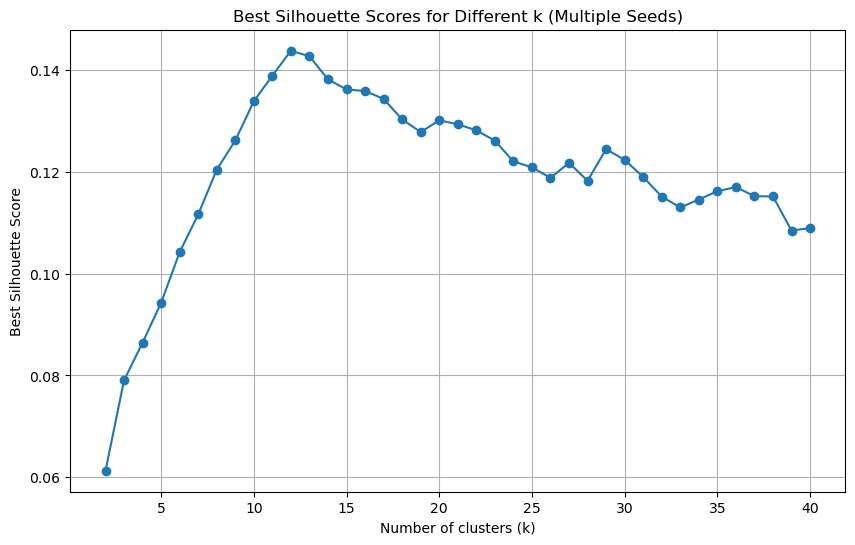

Optimal number of clusters: 12


In [106]:
optimal_k, best_labels, best_model = find_optimal_clusters_random(embeddings, max_k=40, n_init_passes=10)

# Apply cluster label to training list

In [107]:
# kmeans = KMeans(n_clusters=optimal_k, random_state=42)
# labels = kmeans.fit_predict(embeddings)
# print(labels)

print(Counter(best_labels))
clusterized_trainings_data = map_cluster_to_trainings_data(trainings_data, best_labels)

filename = f"clusterized_trainings_{training_data_version}.json"
save_path = DATA_TRAININGS_DIR / filename
save_json(save_path, clusterized_trainings_data)

Counter({np.int32(9): 90, np.int32(3): 60, np.int32(8): 55, np.int32(5): 42, np.int32(4): 39, np.int32(6): 34, np.int32(2): 32, np.int32(10): 31, np.int32(11): 31, np.int32(0): 30, np.int32(7): 28, np.int32(1): 25})


# Analyze cluster distribution

In [108]:
analyse_cluster_distribution(best_labels, training_list)

Cluster 9: compliance, financial, insurance, professionals, risk
Cluster 5: circuit, complex, electrical, electronic, systems
Cluster 6: food, learn, manufacturing, production, safety
Cluster 7: compliance, environmental, fiber, manufacturing, paper
Cluster 4: equipment, industrial, machinery, maintenance, techniques
Cluster 10: procurement, purchasing, strategic, supplier, supply
Cluster 3: guest, hotel, professionals, reception, tourism
Cluster 2: complex, legal, professional, professionals, techniques
Cluster 8: maritime, operations, port, safety, transport
Cluster 11: art, artistic, creative, techniques, visual
Cluster 0: digital, document, information, management, systems
Cluster 1: equipment, live, safety, technical, technicians


# Apply sub clustering on biggest cluster

In [15]:
filename = f"clusterized_trainings_{training_data_version}.json"
save_path = DATA_TRAININGS_DIR / filename
clusterized_trainings_data = read_json(save_path)

# Convert to TrainingInfo objects
clusterized_trainings_info = {
    training_id: TrainingInfo.model_validate_json(data)
    for training_id, data in clusterized_trainings_data.items()
}

In [20]:
map_clusters_trainings = {}
for training_id in clusterized_trainings_data:
    training_data_dict = json.loads(clusterized_trainings_data[training_id])
    skill_domain = training_data_dict['skill_domain']
    
    if skill_domain not in map_clusters_trainings:
        map_clusters_trainings[skill_domain] = []

    map_clusters_trainings[skill_domain].append(training_id)

Processing main cluster CLUSTER_9
90


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(90, 384)


100%|██████████| 16/16 [00:34<00:00,  2.17s/it]


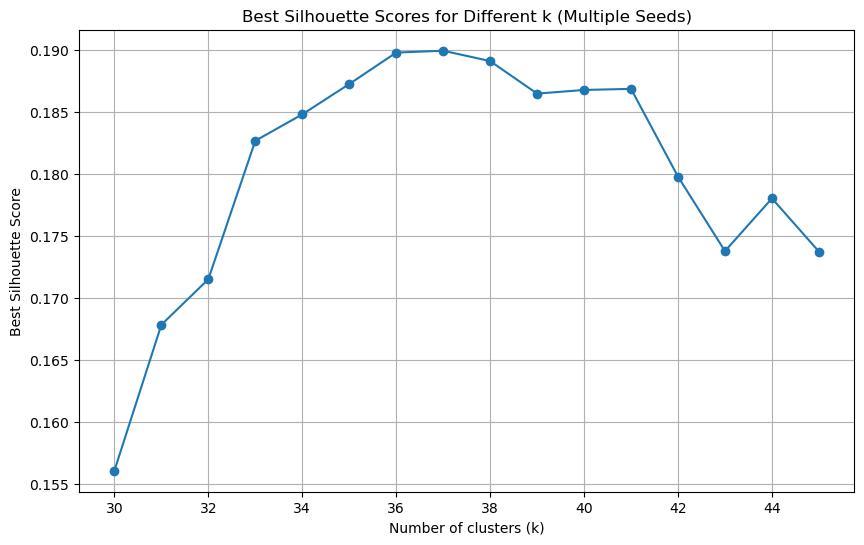

Optimal number of clusters: 37
Counter({np.int32(12): 3, np.int32(3): 3, np.int32(36): 3, np.int32(34): 3, np.int32(30): 3, np.int32(20): 3, np.int32(2): 3, np.int32(31): 3, np.int32(28): 3, np.int32(8): 3, np.int32(19): 3, np.int32(21): 3, np.int32(9): 3, np.int32(16): 3, np.int32(13): 3, np.int32(4): 3, np.int32(0): 3, np.int32(14): 3, np.int32(1): 3, np.int32(26): 3, np.int32(10): 3, np.int32(7): 2, np.int32(22): 2, np.int32(25): 2, np.int32(6): 2, np.int32(15): 2, np.int32(17): 2, np.int32(23): 2, np.int32(27): 2, np.int32(5): 2, np.int32(32): 2, np.int32(18): 2, np.int32(24): 1, np.int32(35): 1, np.int32(33): 1, np.int32(29): 1, np.int32(11): 1})
Cluster 12: accounting, complex, financial, software, tools
Cluster 3: analysis, cost, financial, interpreting, techniques
Cluster 7: analysis, analyzing, data, drawing, information
Cluster 22: analytics, apply, best, business, complex
Cluster 25: compliance, essential, financial, foundational, reporting
Cluster 36: complex, compliance, e

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(42, 384)


100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


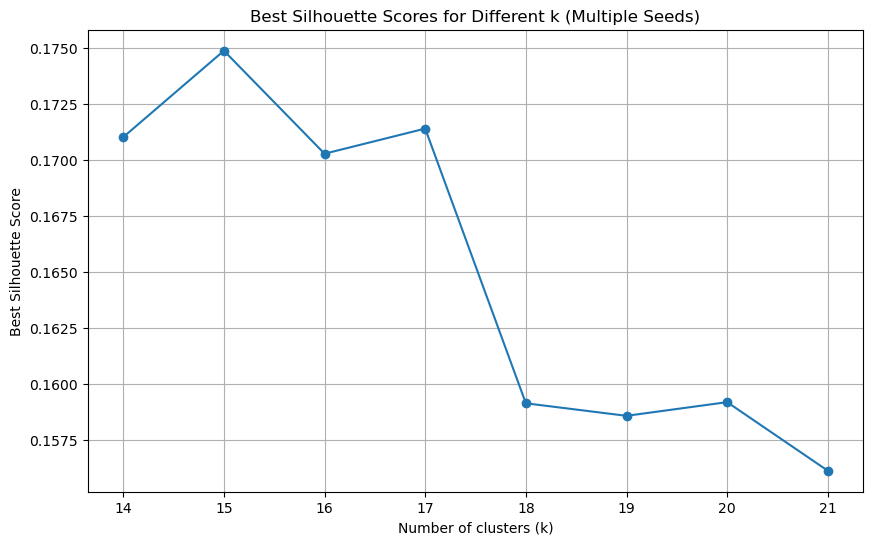

Optimal number of clusters: 15
Counter({np.int32(5): 3, np.int32(0): 3, np.int32(7): 3, np.int32(4): 3, np.int32(2): 3, np.int32(3): 3, np.int32(10): 3, np.int32(8): 3, np.int32(14): 3, np.int32(12): 3, np.int32(1): 3, np.int32(9): 3, np.int32(6): 2, np.int32(13): 2, np.int32(11): 2})
Cluster 5: devices, embedded, programming, systems, techniques
Cluster 0: complex, distribution, electrical, power, systems
Cluster 6: electrical, gain, networks, power, wiring
Cluster 7: compliance, electrical, hazard, protective, safety
Cluster 4: circuit, complex, diagram, electrical, interpretation
Cluster 2: components, connections, electronic, joining, quality
Cluster 3: electrical, electronic, equipment, mastery, testing
Cluster 10: apply, circuits, electronic, failures, systems
Cluster 13: ability, complex, documentation, schematic, technical
Cluster 8: control, electrical, industrial, power, systems
Cluster 11: apply, best, circuit, compliance, electronic
Cluster 14: cable, efficiency, organizati

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(34, 384)


100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


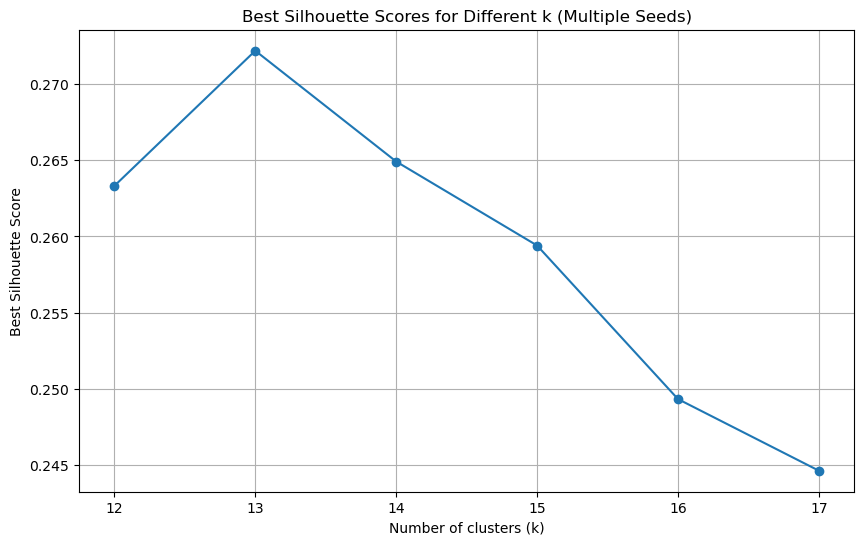

Optimal number of clusters: 13
Counter({np.int32(11): 3, np.int32(6): 3, np.int32(1): 3, np.int32(3): 3, np.int32(0): 3, np.int32(8): 3, np.int32(12): 3, np.int32(4): 3, np.int32(5): 3, np.int32(2): 2, np.int32(7): 2, np.int32(9): 2, np.int32(10): 1})
Cluster 11: chemical, environments, handling, proper, protocols
Cluster 10: apply, best, compliance, disposal, environmental
Cluster 6: control, critical, food, manufacturing, safety
Cluster 1: environments, food, safety, sanitation, standards
Cluster 2: essential, food, industry, management, materials
Cluster 3: design, food, packaging, safety, solutions
Cluster 0: food, innovation, market, new, products
Cluster 8: food, manufacturing, operations, production, workflows
Cluster 12: assessment, compliance, food, safety, standards
Cluster 7: ability, adjustment, consistency, recipe, scaling
Cluster 9: distribution, food, inventory, management, networks
Cluster 4: food, reduction, sources, techniques, waste
Cluster 5: complex, compliance, le

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(28, 384)


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


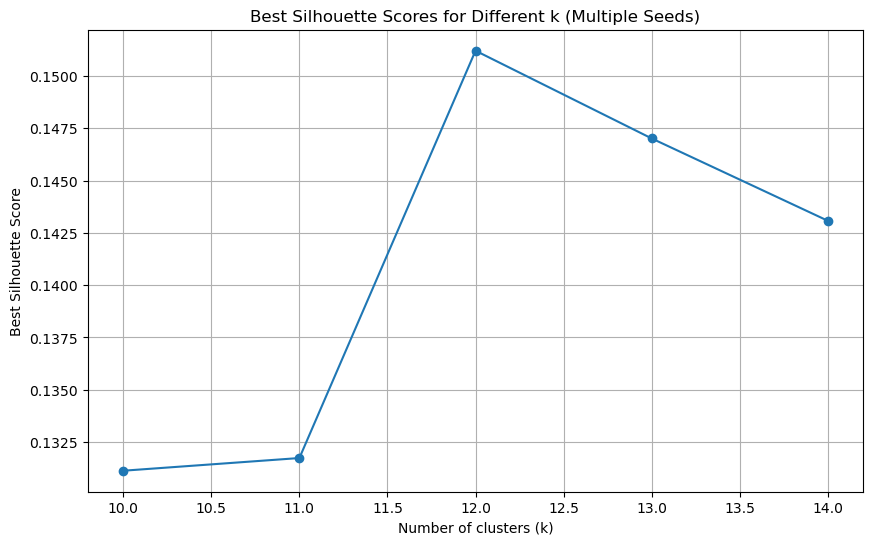

Optimal number of clusters: 12
Counter({np.int32(3): 3, np.int32(1): 3, np.int32(4): 3, np.int32(8): 3, np.int32(9): 3, np.int32(5): 3, np.int32(0): 2, np.int32(7): 2, np.int32(11): 2, np.int32(2): 2, np.int32(6): 1, np.int32(10): 1})
Cluster 3: complex, compliance, environmental, regulatory, standards
Cluster 6: analysis, evaluation, material, properties, science
Cluster 0: analysis, complex, core, fiber, science
Cluster 1: industrial, manufacturing, paper, production, techniques
Cluster 7: bottlenecks, efficiency, identifying, manufacturing, production
Cluster 4: development, industry, paper, product, products
Cluster 8: fiber, manufacturing, paper, processes, processing
Cluster 9: assurance, manufacturing, paper, pulp, quality
Cluster 11: environmental, fiber, managing, manufacturing, paper
Cluster 2: apply, best, compliance, foundational, regulatory
Cluster 5: com, embarcações, nível, para, portuárias
Cluster 10: aircraft, compliance, create, documentation, technical
Processing mai

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(39, 384)


100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


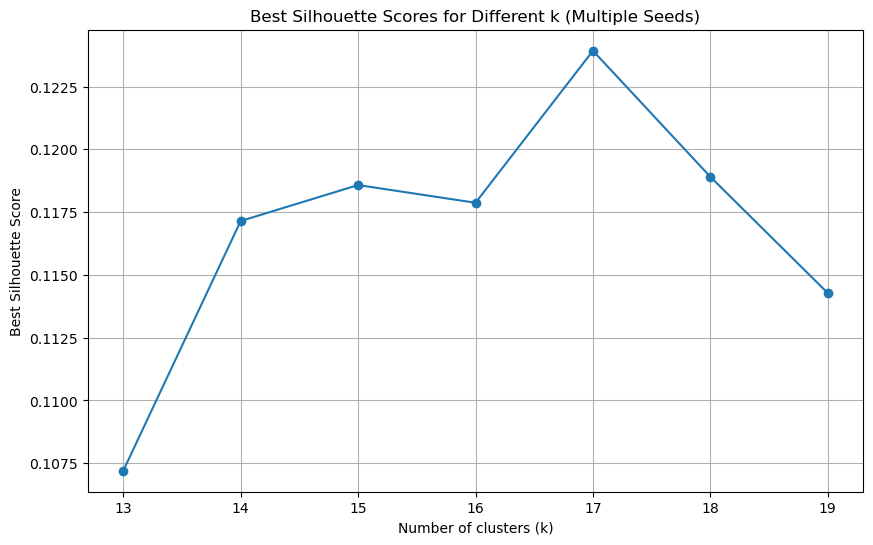

Optimal number of clusters: 17
Counter({np.int32(6): 3, np.int32(9): 3, np.int32(3): 3, np.int32(7): 3, np.int32(1): 3, np.int32(15): 3, np.int32(10): 3, np.int32(5): 3, np.int32(4): 3, np.int32(2): 2, np.int32(14): 2, np.int32(12): 2, np.int32(8): 2, np.int32(16): 1, np.int32(13): 1, np.int32(0): 1, np.int32(11): 1})
Cluster 6: complex, equipment, industrial, machinery, operation
Cluster 2: complex, equipment, machinery, management, operation
Cluster 16: bottlenecks, covers, enhancing, manufacturing, streamlining
Cluster 14: apply, equipment, foundational, industrial, safety
Cluster 13: blueprint, covers, environments, schematic, technical
Cluster 9: causes, environments, equipment, problemsolving, systematic
Cluster 0: calibrate, calibration, compliance, equipment, standards
Cluster 12: calibration, instrument, measurement, precision, techniques
Cluster 3: applications, hydraulic, industrial, pneumatic, systems
Cluster 7: fabrication, industrial, metal, metalworking, techniques
Clust

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(31, 384)


100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


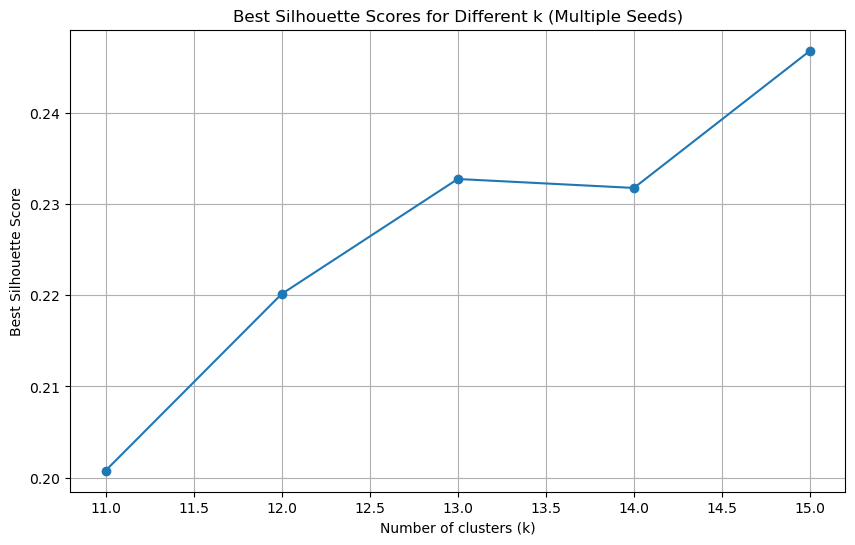

Optimal number of clusters: 15
Counter({np.int32(8): 3, np.int32(5): 3, np.int32(7): 3, np.int32(6): 3, np.int32(1): 2, np.int32(10): 2, np.int32(2): 2, np.int32(3): 2, np.int32(0): 2, np.int32(11): 2, np.int32(13): 2, np.int32(4): 2, np.int32(9): 1, np.int32(14): 1, np.int32(12): 1})
Cluster 1: complex, compliance, environments, food, procurement
Cluster 9: analysis, comprehensive, longterm, organizational, strategy
Cluster 10: chain, coordination, logistics, management, procurement
Cluster 2: apply, best, compliance, credential, negotiation
Cluster 14: better, complex, deals, drive, negotiation
Cluster 3: apply, best, compliance, contract, management
Cluster 12: agreements, commercial, complex, contract, drafting
Cluster 0: analyzing, better, cost, creating, reduction
Cluster 11: analytics, data, opportunities, procurement, purchasing
Cluster 13: chain, distribution, fundamentals, management, supply
Cluster 4: analysis, comprehensive, intelligence, market, research
Cluster 8: erp, pr

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(60, 384)


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


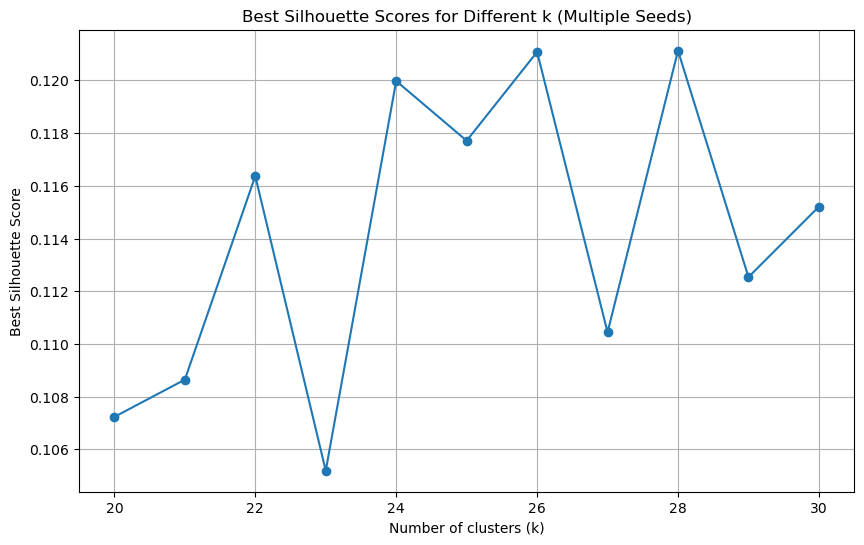

Optimal number of clusters: 28
Counter({np.int32(3): 3, np.int32(12): 3, np.int32(21): 3, np.int32(18): 3, np.int32(15): 3, np.int32(11): 3, np.int32(1): 3, np.int32(23): 3, np.int32(9): 3, np.int32(17): 3, np.int32(2): 3, np.int32(6): 3, np.int32(10): 2, np.int32(8): 2, np.int32(13): 2, np.int32(26): 2, np.int32(0): 2, np.int32(5): 2, np.int32(4): 2, np.int32(7): 2, np.int32(20): 1, np.int32(16): 1, np.int32(24): 1, np.int32(14): 1, np.int32(25): 1, np.int32(27): 1, np.int32(19): 1, np.int32(22): 1})
Cluster 3: accurate, guest, hotel, money, reception
Cluster 12: departure, guest, hotel, procedures, processing
Cluster 10: complex, guest, handle, reception, situations
Cluster 21: desk, essential, guest, hotel, reception
Cluster 18: client, compliance, guest, resolution, techniques
Cluster 15: guest, handling, management, operations, reception
Cluster 11: customer, excellence, experiences, service, techniques
Cluster 8: area, essential, hotel, knowledge, reception
Cluster 20: atrações, 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(32, 384)


100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


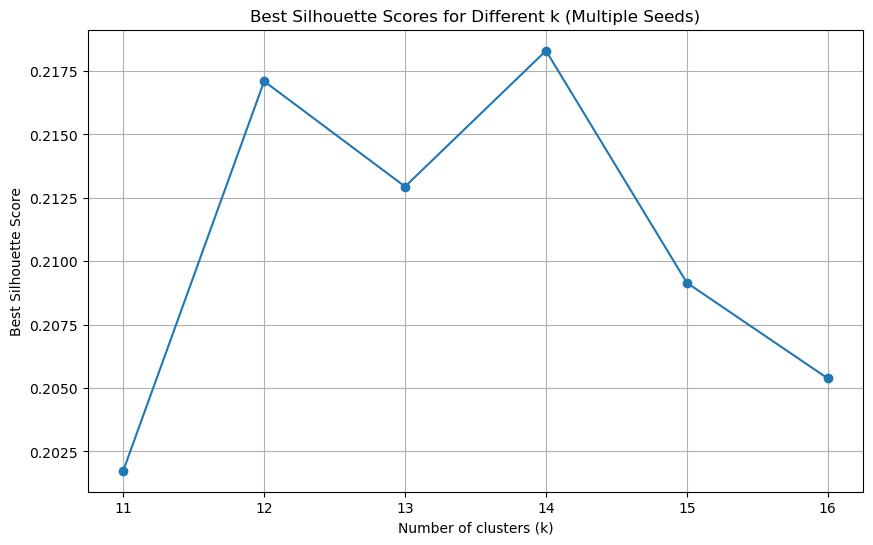

Optimal number of clusters: 14
Counter({np.int32(7): 3, np.int32(2): 3, np.int32(4): 3, np.int32(1): 3, np.int32(12): 3, np.int32(3): 3, np.int32(5): 3, np.int32(0): 2, np.int32(10): 2, np.int32(11): 2, np.int32(13): 2, np.int32(6): 1, np.int32(9): 1, np.int32(8): 1})
Cluster 6: client, essential, foundational, fundamentals, interaction
Cluster 7: analysis, complex, court, decisions, legal
Cluster 2: client, clients, counseling, legal, techniques
Cluster 0: agreements, dispute, document, foundational, legal
Cluster 10: agreement, complex, comprehensive, legal, writing
Cluster 4: dilemmas, legal, moral, practice, professional
Cluster 1: analysis, case, databases, legal, research
Cluster 12: clear, document, drafting, legal, professional
Cluster 11: case, complex, disputes, legal, procedures
Cluster 3: apply, best, compliance, techniques, transparency
Cluster 9: advocacy, bargaining, communication, conflict, techniques
Cluster 5: courtroom, legal, presentation, settings, techniques
Clust

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(55, 384)


100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


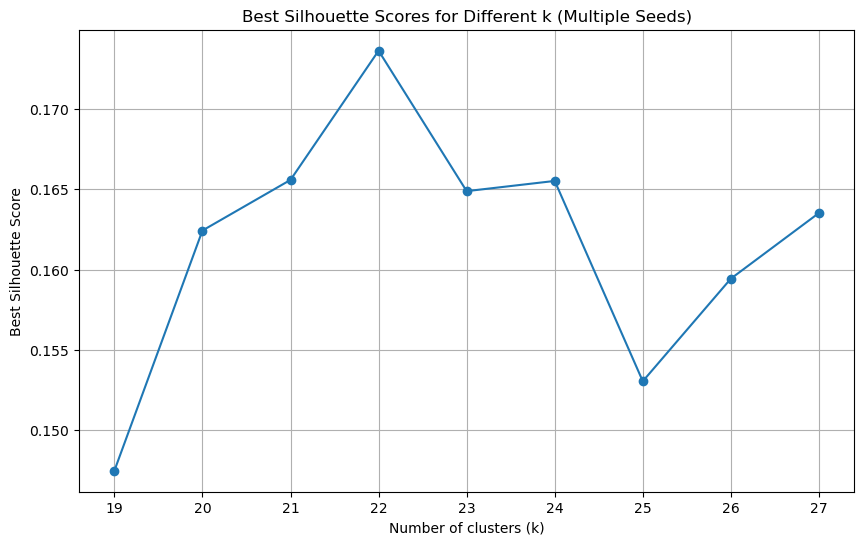

Optimal number of clusters: 22
Counter({np.int32(16): 3, np.int32(6): 3, np.int32(5): 3, np.int32(15): 3, np.int32(18): 3, np.int32(1): 3, np.int32(0): 3, np.int32(11): 3, np.int32(9): 3, np.int32(17): 3, np.int32(13): 3, np.int32(2): 3, np.int32(3): 3, np.int32(10): 3, np.int32(20): 2, np.int32(12): 2, np.int32(7): 2, np.int32(8): 2, np.int32(14): 2, np.int32(19): 1, np.int32(21): 1, np.int32(4): 1})
Cluster 16: cargo, handling, loading, maritime, operations
Cluster 6: communication, digital, essential, maritime, radio
Cluster 20: coordination, essential, maritime, operations, port
Cluster 12: compliance, documentation, international, procedures, trade
Cluster 7: equipment, heavy, machinery, operating, operation
Cluster 5: cargo, handling, operations, port, terminal
Cluster 19: best, compliance, credential, port, safety
Cluster 8: compliance, expertise, management, port, safety
Cluster 15: coordinating, essential, managing, operations, vessel
Cluster 21: allocation, apply, best, compl

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(31, 384)


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


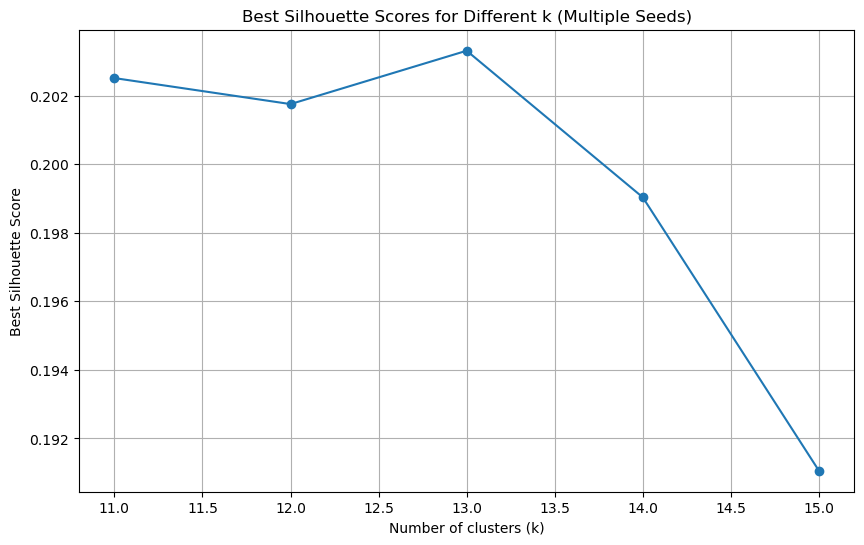

Optimal number of clusters: 13
Counter({np.int32(3): 3, np.int32(5): 3, np.int32(9): 3, np.int32(2): 3, np.int32(6): 3, np.int32(1): 3, np.int32(7): 3, np.int32(8): 2, np.int32(10): 2, np.int32(4): 2, np.int32(0): 2, np.int32(12): 1, np.int32(11): 1})
Cluster 12: ability, blueprints, complex, detailed, technical
Cluster 3: appreciation, artistic, history, periods, understanding
Cluster 5: artistic, creative, ideas, techniques, visual
Cluster 9: canvas, color, creative, develop, techniques
Cluster 2: color, colors, harmony, palettes, visual
Cluster 8: arrangement, balance, design, elements, visual
Cluster 10: capture, create, creative, learn, visual
Cluster 6: art, digital, professional, software, techniques
Cluster 4: composition, drawing, shading, sketching, techniques
Cluster 11: artistic, developing, illustration, representation, techniques
Cluster 1: artistic, materials, properties, techniques, understanding
Cluster 0: creative, portfolio, presentation, professional, showcase
Clust

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(30, 384)


100%|██████████| 6/6 [00:02<00:00,  2.44it/s]


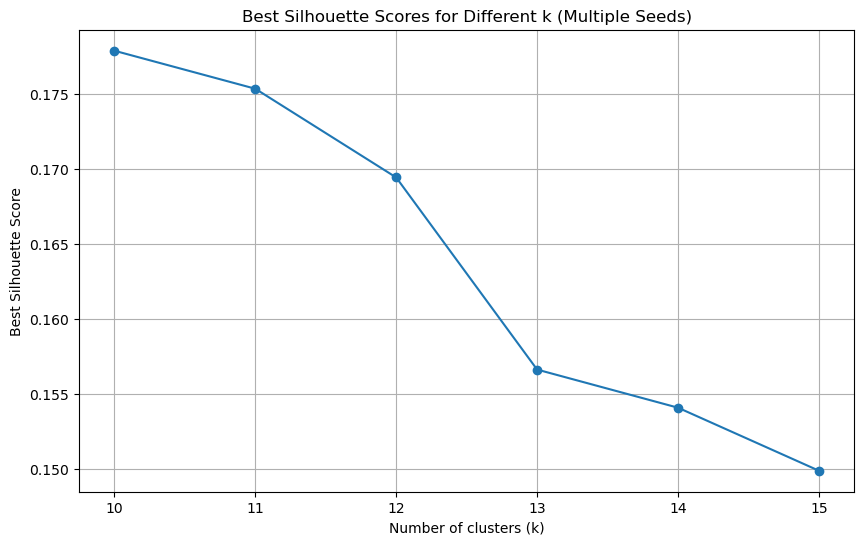

Optimal number of clusters: 10
Counter({np.int32(7): 3, np.int32(5): 3, np.int32(2): 3, np.int32(8): 3, np.int32(3): 3, np.int32(6): 3, np.int32(1): 3, np.int32(0): 3, np.int32(9): 3, np.int32(4): 3})
Cluster 7: creating, document, information, maintaining, structuring
Cluster 5: authentication, management, permission, systems, user
Cluster 2: compliance, data, privacy, protection, regulatory
Cluster 8: content, digital, management, platforms, website
Cluster 3: data, digital, information, security, techniques
Cluster 6: collections, digital, including, management, preserving
Cluster 1: control, document, management, scenarios, version
Cluster 0: content, creating, digital, metadata, systems
Cluster 9: complex, data, efficiently, information, search
Cluster 4: compliance, document, management, policy, retention
Processing main cluster CLUSTER_1
25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(25, 384)


100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


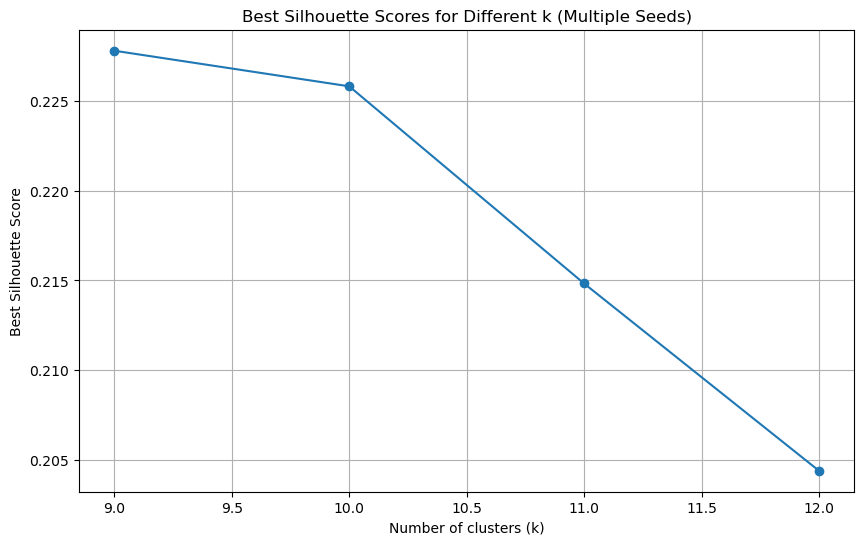

Optimal number of clusters: 9
Counter({np.int32(0): 3, np.int32(1): 3, np.int32(2): 3, np.int32(7): 3, np.int32(3): 3, np.int32(5): 3, np.int32(6): 3, np.int32(8): 2, np.int32(4): 2})
Cluster 0: audio, configuration, equipment, sound, systems
Cluster 8: circuits, electrical, environments, power, safety
Cluster 1: communication, information, live, performer, team
Cluster 4: diagnosis, entertainment, equipment, live, problem
Cluster 2: equipment, lighting, protocols, setup, stage
Cluster 7: coordinating, live, management, performances, production
Cluster 3: live, management, procedures, protocols, safety
Cluster 5: equipment, rigging, stage, systems, theatrical
Cluster 6: display, projection, setups, technology, visual


In [21]:
for active_cluster in map_clusters_trainings:
    print(f"Processing main cluster {active_cluster}")
    map_cluster_trainings = map_clusters_trainings[active_cluster]

    # description_type = 'full'
    description_type = 'short'

    training_list = []
    sub_training_data = {}

    for training_id in map_cluster_trainings:
        sub_training_data[training_id] = clusterized_trainings_data[training_id]
        if description_type == 'short':
            training_info = clusterized_trainings_info[training_id]
            training_list.append(training_info.describe_short())
        else:
            training_list.append(training_descriptions[training_id])

    stopwords = set([
        'description', 'skill', 'title', 'training', 'advanced', 'intermediate',
        'level', 'job', 'role', 'position', 'll', 'online', 'youll', 'certification', 'course',
        'format', 'basic', 'master', 'duration', 'weeks', 'strengthen', 'practices', 'skills',
        'work'
    ])

    training_list = [clean_text(text) for text in training_list]

    print(len(training_list))

    sub_embeddings = generate_embeddings(training_list)
    print(sub_embeddings.shape)

    sub_optimal_k, sub_best_labels, sub_best_model = find_optimal_clusters_random(
        sub_embeddings,
        max_k=int(len(training_list) / 2),
        n_init_passes=10,
        algo='KMeansConstrained',
        size_max=3
    )

    print(Counter(sub_best_labels))
    analyse_cluster_distribution(sub_best_labels, training_list)

    sub_clusterized_trainings_data = map_cluster_to_trainings_data(sub_training_data, sub_best_labels, mode='skill_acquired')
    # print(sub_clusterized_trainings_data)

    for training_id in sub_clusterized_trainings_data:
        clusterized_trainings_data[training_id] = sub_clusterized_trainings_data[training_id]

    # print(clusterized_trainings_data)

    filename = f"clusterized_trainings_{training_data_version}.json"
    save_path = DATA_TRAININGS_DIR / filename
    save_json(save_path, clusterized_trainings_data)

# Find best name for cluster label

In [99]:
def extract_training_info(
    text,
    model: str = "mistral-small-latest",
    print_prompt=False
) -> str:
    """Extract training info from file using Training Extraction Agent"""

    prompt = f"Generate a short, meaningful name for a training category based on this text: {text}"

    if print_prompt is True:
        print(prompt)
    extraction_agent = get_agent(model_id=model, temperature=0.0)
    result = extraction_agent(prompt=prompt)

    if hasattr(extraction_agent, 'last_response'):
        track_api_call(extraction_agent.last_response, model)

    return result

Cluster 9: compliance, financial, insurance, professionals, risk
Cluster 5: circuit, complex, electrical, electronic, systems
Cluster 6: food, learn, manufacturing, production, safety
Cluster 7: compliance, environmental, fiber, manufacturing, paper
Cluster 4: equipment, machinery, maintenance, production, techniques
Cluster 10: procurement, purchasing, strategic, supplier, supply
Cluster 3: guest, hotel, professionals, reception, tourism
Cluster 2: complex, legal, professional, professionals, techniques
Cluster 8: maritime, operations, port, safety, transport
Cluster 11: art, artistic, creative, techniques, visual
Cluster 0: digital, document, information, management, systems
Cluster 1: equipment, live, safety, technical, technicians
